In [ ]:
from google.colab import files
files.upload()

In [ ]:
# prompt: download flickr30k
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k



mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [ ]:
!unzip flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [ ]:
import os

# List the files in the directory to check if the images are there
images_path = '/content/flickr8k/Images/'
print(os.listdir(images_path)[:10])  # Display the first 10 files


['3577235421_69e4efb8d1.jpg', '3448855727_f16dea7b03.jpg', '3550763985_800cfee7e4.jpg', '3710520638_866d542a80.jpg', '3434452829_62cee280bc.jpg', '3109124656_626b596d5e.jpg', '3265527323_6431f00692.jpg', '2138487671_5b89104043.jpg', '3692746368_ab7d97ab31.jpg', '3471066276_fb1e82e905.jpg']


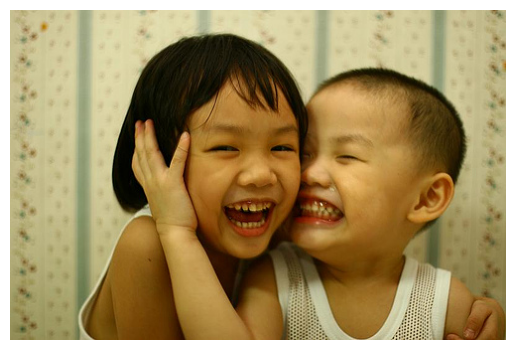

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/flickr8k/Images/2886837407_a4510ab1ef.jpg'

try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
except FileNotFoundError:
    print("File not found. Please check the path.")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, array_to_img

import numpy as np
import pickle
from PIL import Image, UnidentifiedImageError

In [ ]:
def load_caption_file(path):
    captions_dict = {}

    for caption in open(path):
        # Split line into image name and the caption part
        tokens = caption.strip().split()
        img_id_with_caption_num = tokens[0]  # e.g., "1000268201_693b08cb0e.jpg#0"
        img_id = img_id_with_caption_num.split('#')[0].split('.')[0]  # remove .jpg and #index
        caption_text = ' '.join(tokens[1:])  # rest is the actual caption

        # Append captions to the list
        if img_id not in captions_dict:
            captions_dict[img_id] = [caption_text]
        else:
            captions_dict[img_id].append(caption_text)

    return captions_dict
captions_path = '/content/flickr8k/captions.txt'
captions_dict = load_caption_file(captions_path)

In [ ]:
captions_dict['2886837407_a4510ab1ef']

['asian children smile while hugging each other .',
 'children grin and hug each other .',
 'children hug and smile .',
 'children smile for the camera .',
 'kids hugging each other .']

In [ ]:
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, captions in captions_dict.items():
    cleaned_captions = []
    for caption_text in captions:
        # tokenize the caption_text
        tokens = caption_text.split()
        # convert to lower case
        tokens = [token.lower() for token in tokens]
        # remove punctuation
        tokens = [token.translate(table) for token in tokens]
        # remove short tokens (like 'a', 's')
        tokens = [token for token in tokens if len(token) > 1]
        # wrap with start and end tags
        cleaned_caption = 'startseq ' + ' '.join(tokens) + ' endseq'
        cleaned_captions.append(cleaned_caption)

    # store cleaned captions
    new_captions_dict[caption_id] = cleaned_captions


In [ ]:
del captions_dict

In [ ]:
len(new_captions_dict)


8092

In [ ]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]


In [ ]:
len(caption_images_list)


8091

In [ ]:
train_validate_images = caption_images_list[0:8070]


In [ ]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)


    return features

In [ ]:
train_validate_features = extract_features(images_path, train_validate_images)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:

# Save the features to a pickle file
with open('train_validate_features.pkl', 'wb') as f:
    pickle.dump(train_validate_features, f)


In [ ]:
import pickle
# Load the features from the pickle file
with open('train_validate_features.pkl', 'rb') as f:
    train_validate_features = pickle.load(f)


In [ ]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

3577235421_69e4efb8d1 : [[0.        0.        1.7880977 ... 0.        0.        0.       ]]


In [ ]:
train_validate_features[list(train_validate_features.keys())[0]].shape

(1, 4096)

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8070

In [ ]:
list(train_validate_image_caption.values())[1]


['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq dogs of different breeds looking at each other on the road endseq',
 'startseq dogs on pavement moving toward each other endseq']

In [ ]:
import random
import re
import nltk
from nltk.corpus import wordnet

# Ensure NLTK data is downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clean and tokenize
def clean_caption(caption):
    caption = re.sub(r'[^\w\s]', '', caption)
    words = caption.lower().split()
    return words

# Synonym replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words[:]
    random.shuffle(new_words)
    replaced = 0
    for i, word in enumerate(new_words):
        synonyms = get_synonyms(word)
        if synonyms:
            new_words[i] = random.choice(synonyms)
            replaced += 1
        if replaced >= n:
            break
    return new_words

# Random deletion
def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [word for word in words if random.uniform(0,1) > p]

def random_swap(words, n=1):
    if len(words) < 2:  # Handle case with less than 2 words
        return words

    new_words = words[:]
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

# Augmentation pipeline
def augment_caption(caption, num_augments=3):
    words = clean_caption(caption)
    augments = []

    for _ in range(num_augments):
        choice = random.choice(['synonym', 'swap', 'delete'])

        if choice == 'synonym':
            augmented = synonym_replacement(words, n=2)
        elif choice == 'swap':
            augmented = random_swap(words, n=2)
        else:
            augmented = random_deletion(words, p=0.1)

        aug_caption = ' '.join(augmented)
        augments.append(f"startseq {aug_caption} endseq")

    return augments


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def augment_caption_dict(caption_dict, num_augments=2):
    augmented_caption_dict = {}

    for image_id, captions in caption_dict.items():
        all_captions = []

        for caption in captions:
            # Remove startseq/endseq before augmentation
            clean_caption = caption.replace("startseq", "").replace("endseq", "").strip()
            all_captions.append(caption.strip())  # Keep original

            # Add augmentations
            augments = augment_caption(clean_caption, num_augments=num_augments)
            all_captions.extend(augments)

        augmented_caption_dict[image_id] = all_captions

    return augmented_caption_dict


In [ ]:
augmented_dict = augment_caption_dict(train_validate_image_caption, num_augments=3)

In [ ]:
list(augmented_dict.values())[0]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq nestling inwards way dress in set pink entry stairs of up climbing is an endseq',
 'startseq ping Indiana an set stairs is up entry way child dress of climbing in endseq',
 'startseq child in pink dress is climbing of in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq going into wooden building endseq',
 'startseq wooden into young lady survive building endseq',
 'startseq girl into wooden going building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little climbing girl wooden into playhouse endseq',
 'startseq into wax wooden small playhouse girl endseq',
 'startseq little girl climbing into wooden endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq her the picayune to female child climbing playhouse stairs endseq',
 'startseq little girl climbing the stairs to her endseq',
 'start

In [ ]:
from collections import defaultdict

def remove_redundancy(augmented_dict):
    """Removes redundant captions from the augmented dictionary."""
    unique_captions = defaultdict(set)
    for image_id, captions in augmented_dict.items():
        for caption in captions:
            unique_captions[image_id].add(caption)
    return dict(unique_captions)

cleaned_augmented_dict = remove_redundancy(augmented_dict)

# Now cleaned_augmented_dict contains only unique captions for each image
list(cleaned_augmented_dict.values())[0]


{'startseq Indiana cabin into young woman wooden pink going dress little endseq',
 'startseq child in pink dress is climbing of in an entry way endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq girl into wooden going building endseq',
 'startseq going into wooden building endseq',
 'startseq her the picayune to female child climbing playhouse stairs endseq',
 'startseq into cabin garden pink little girl in going little dress wooden endseq',
 'startseq into wax wooden small playhouse girl endseq',
 'startseq little climbing girl wooden into playhouse endseq',
 'startseq little girl climbing into wooden endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in going into pink dress wooden cabin endseq',
 'startseq lit

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

In [ ]:
# Flatten all captions across all images into a single list
all_captions = [caption for captions in augmented_dict.values() for caption in captions]

# Fit tokenizer on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Get vocabulary size
vocab_len = len(tokenizer.word_index) + 1

# Get maximum caption length
max_len = max(len(caption.split()) for caption in all_captions)


In [ ]:
max_len

33

In [ ]:
vocab_len

13382

In [ ]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, image_ids, captions_dict, features_dict, tokenizer, max_len, vocab_size, batch_size=32):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.features_dict = features_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.indexes = np.arange(len(image_ids))

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):

        batch_image_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]

        x1, x2, y = [], [], []

        for img_id in batch_image_ids:
            captions = self.captions_dict[img_id]
            feature = self.features_dict[img_id][0]

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    x1.append(feature)
                    x2.append(in_seq)
                    y.append(out_seq)

        return (np.array(x1), np.array(x2)), np.array(y)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Concatenate,
    Bidirectional, LayerNormalization, LeakyReLU, Attention
)
from tensorflow.keras.regularizers import l2

# Image feature extractor input (4096 feature vector from CNN like ResNet)
input_1 = Input(shape=(4096,))
dense_img = Dense(256, kernel_regularizer=l2(0.001))(input_1)
dense_img = LeakyReLU(alpha=0.1)(dense_img)
dense_img = LayerNormalization()(dense_img)  # Normalize features
dense_img = Dropout(0.5)(dense_img)

# Text sequence input
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=False)(input_2)
embedding = Dropout(0.5)(embedding)

# Bidirectional LSTM with L2 regularization
lstm = Bidirectional(
    LSTM(256, return_sequences=True, recurrent_activation='sigmoid', kernel_regularizer=l2(0.001))
)(embedding)
lstm = LayerNormalization()(lstm)
lstm = Dropout(0.5)(lstm)

# Attention Mechanism
attention_layer = Attention()([lstm, lstm])
lstm_out = LSTM(256, return_sequences=False)(attention_layer)

# Concatenation of image and text features
decoder1 = Concatenate()([dense_img, lstm_out])
decoder1 = Dense(256, kernel_regularizer=l2(0.001))(decoder1)
decoder1 = LeakyReLU(alpha=0.1)(decoder1)
decoder1 = Dropout(0.5)(decoder1)

# Output layer
outputs = Dense(vocab_len, activation='softmax')(decoder1)

# Define the model
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize model
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 256)   │  3,425,792 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 33, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 33, 512)   │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 33, 512)   │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 33, 512)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ leaky_re_lu[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 33, 512)   │          0 │ dropout_2[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    787,456 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 13382)     │  3,439,174 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,884,742 (37.71 MB)

 Trainable params: 9,884,742 (37.71 MB)

 Non-trainable params: 0 (0.00 B)

None


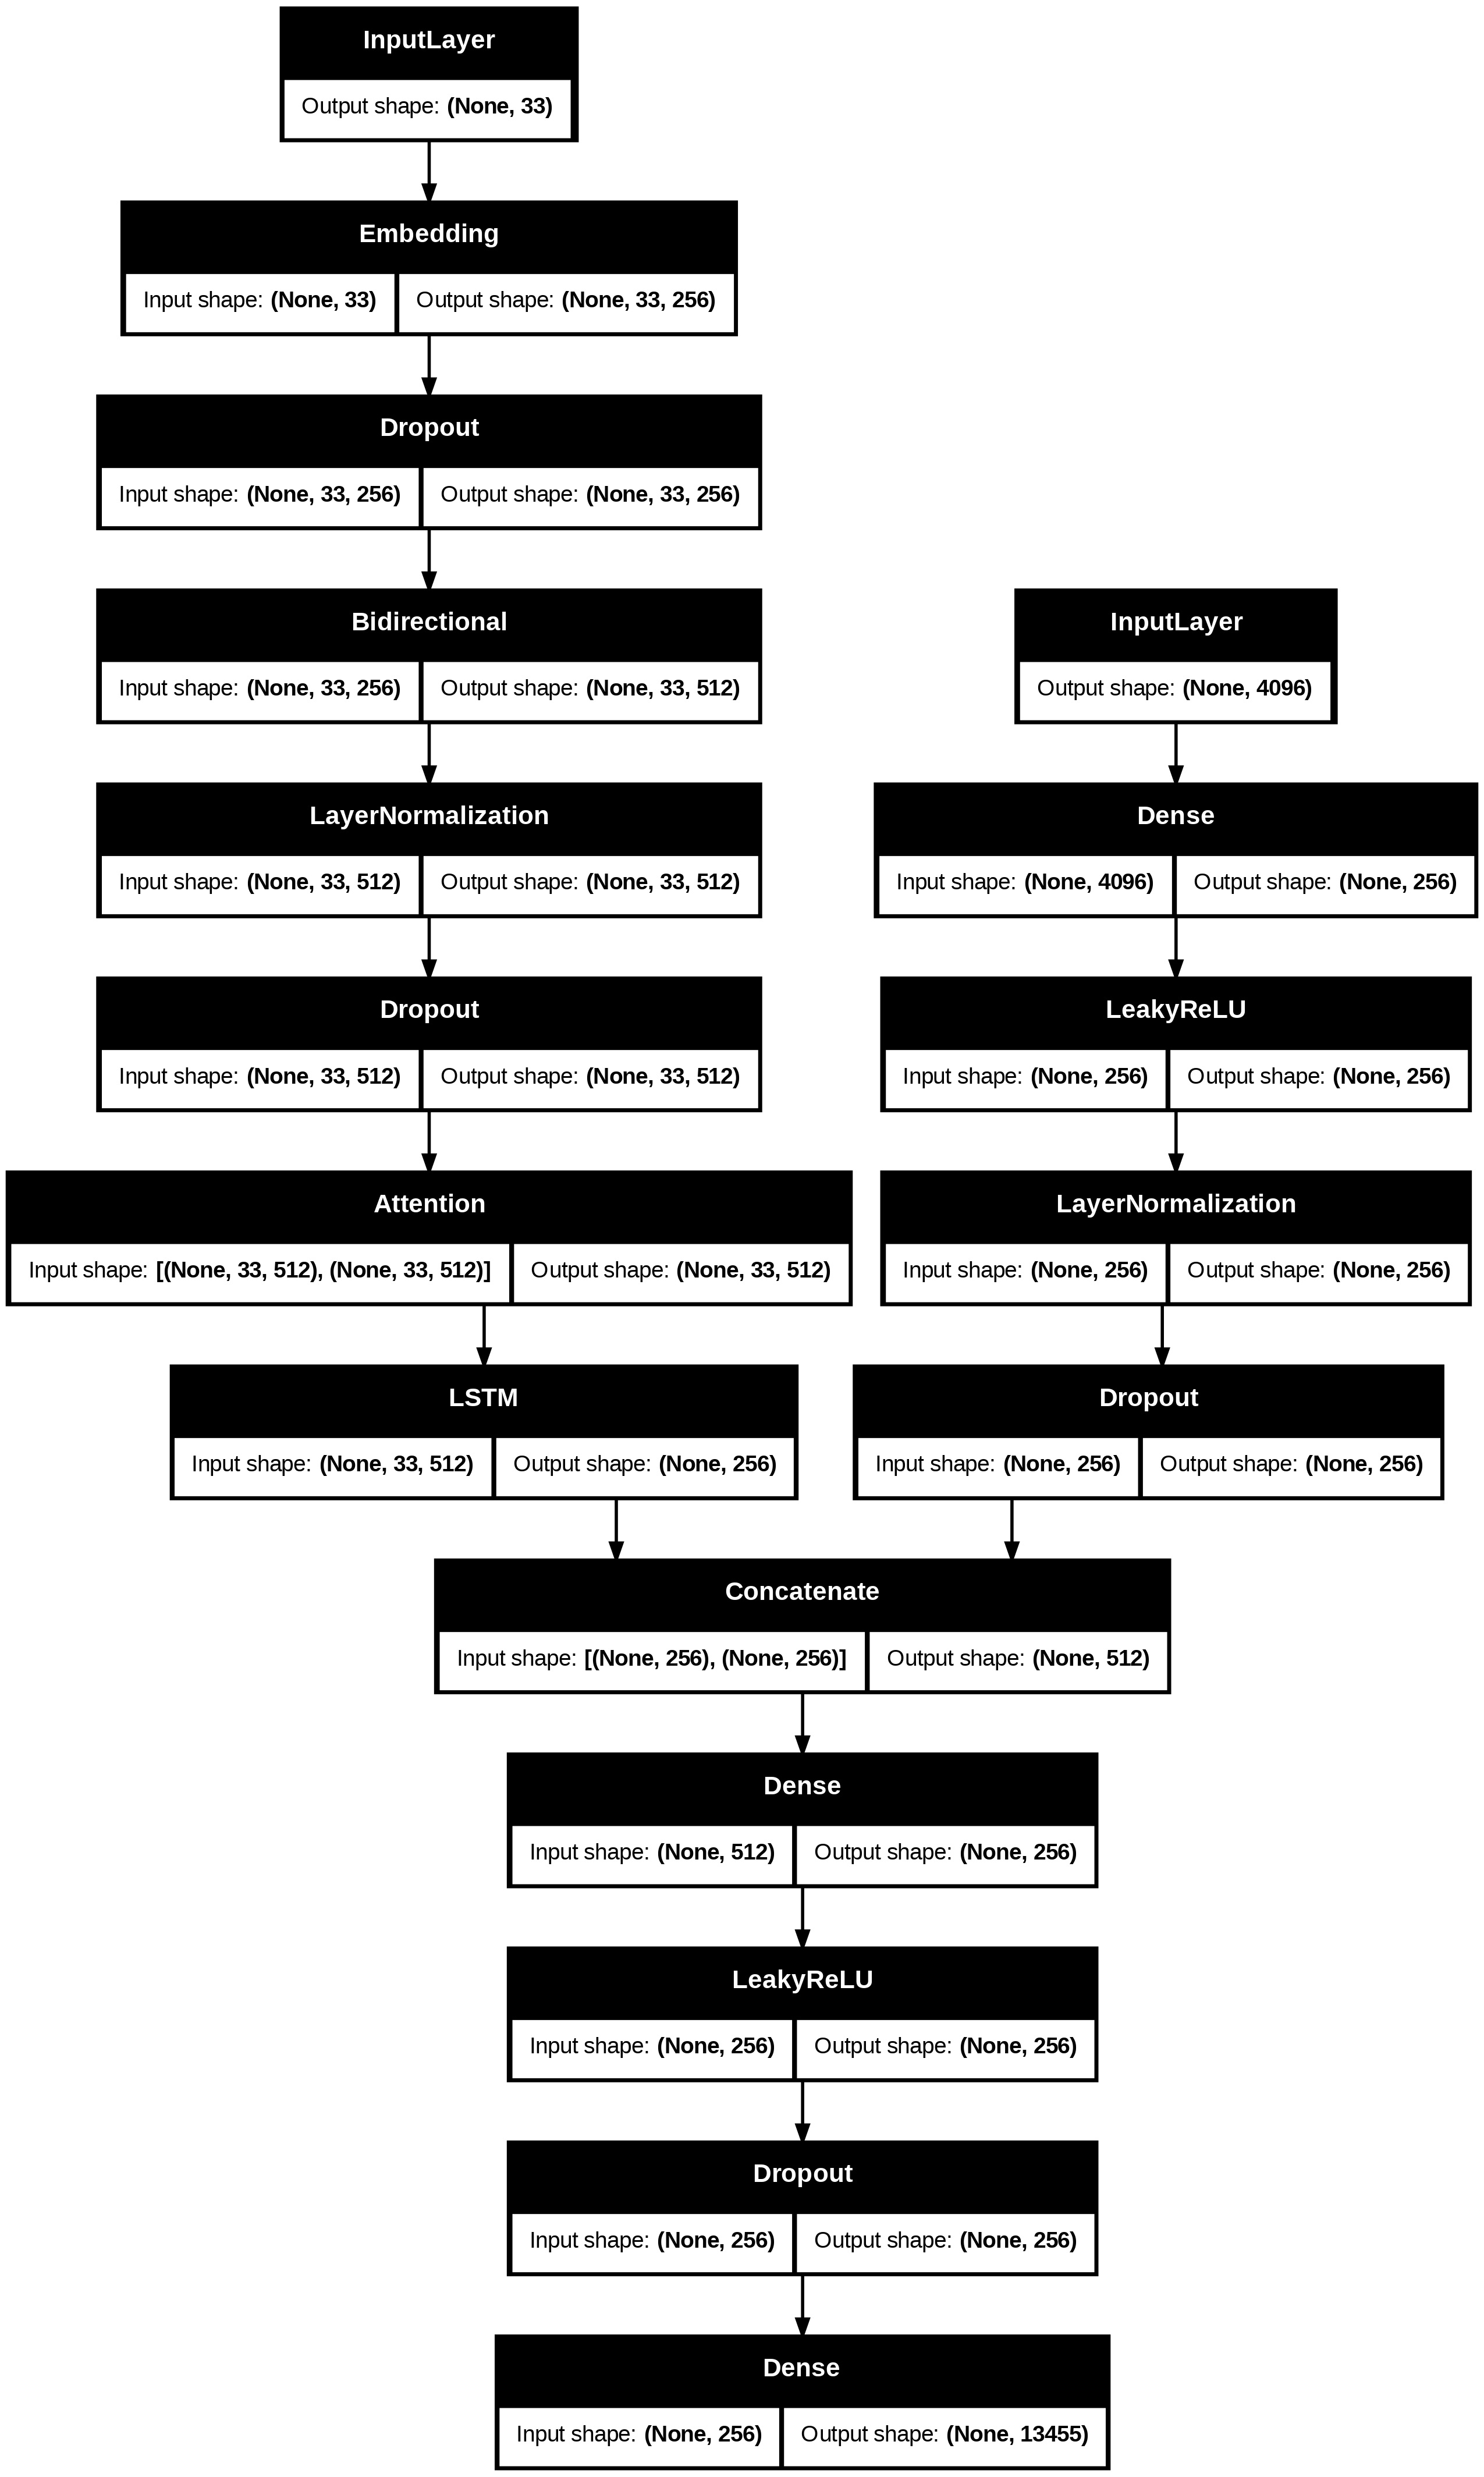

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Save best model
checkpoint_callback = ModelCheckpoint(
    filepath='./best_model.keras',  # Use recommended Keras format
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Stop training if no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Allow more time before stopping
    verbose=1
)

# Reduce LR if val_loss stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Increase patience
    min_lr=1e-5,  # Prevent LR from becoming too small
    verbose=1
)

# Log training process
csv_logger_callback = CSVLogger("training_log.csv", append=True)

# Final callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback, csv_logger_callback]


In [ ]:
from sklearn.model_selection import train_test_split

# image IDs (keys)
image_ids = list(train_validate_image_caption.keys())

# 80% train, 20% validation split
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)


In [ ]:
batch_size = 32

train_generator = DataGenerator(
    image_ids=train_ids,
    captions_dict=cleaned_augmented_dict,
    features_dict=train_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size
)

val_generator = DataGenerator(
    image_ids=val_ids,
    captions_dict=cleaned_augmented_dict,
    features_dict=train_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size
)


In [ ]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.1777
Epoch 1: val_loss improved from inf to 5.69352, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - loss: 7.1738 - val_loss: 5.6935 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.6037
Epoch 2: val_loss improved from 5.69352 to 5.36966, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - loss: 5.6034 - val_loss: 5.3697 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.2762
Epoch 3: val_loss improved from 5.36966 to 5.21327, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - loss: 5.2761 - val_loss: 5.2133 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.0677
Epoch 4: val_loss improved from 5.21327 to 5.11768, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - loss: 5.0676 - val_loss: 5.1177 - learning_r

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
import json

# Let's assume these exist
tokenizer =tokenizer
max_len = max_len
vocab_size =vocab_len

# Save tokenizer itself
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save additional info
metadata = {
    "max_len": max_len,
    "vocab_size": vocab_size
}
with open("tokenizer_meta.json", "w") as f:
    json.dump(metadata, f)


In [ ]:
import pickle
import json
# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load metadata
with open("tokenizer_meta.json", "r") as f:
    metadata = json.load(f)

max_len = metadata["max_len"]
vocab_len = metadata["vocab_size"]


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('./best_model.keras')

# Now you can use the best_model for prediction or further training
print(best_model.summary())


In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
def generate_desc_top_k_hybrid(model, tokenizer, photo, max_length, k=5, greedy_steps=1):
    in_text = 'startseq'
    result = []

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([photo, sequence], verbose=0)[0]

        if i < greedy_steps:
            yhat = np.argmax(yhat)  # Greedy
        else:
            top_k_indices = np.argsort(yhat)[-k:]
            yhat = np.random.choice(top_k_indices)  # Random from top-k

        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break

    final_caption = in_text.split()
    final_caption = final_caption[1:-1] if 'endseq' in final_caption else final_caption[1:]
    return ' '.join(final_caption)


In [ ]:
from IPython.display import Image, display
import os

for count in range(10):
    image_id = caption_images_list[count]
    image_file_path = os.path.join(images_path, image_id + '.jpg')

    if os.path.exists(image_file_path):
        # Extract features
        photo = extract_feat(image_file_path)

        # Print the image ID
        print(f"Image {count+1}: {image_id}")

        # Generate and display 3 distinct captions
        print("📌 Predicted Captions:")
        for i in range(3):  # Generate 3 captions
            description = generate_desc_top_k(best_model, tokenizer, photo, max_len)
            print(f"  {i+1}. {description}")

        print("\n📋 Actual Captions:")

        # Display actual captions
        for i, actual in enumerate(new_captions_dict[image_id]):
            print(f"  {i+1}. {actual}")

        print('\n' + '*' * 70 + '\n')

        # Display the image after captions
        display(Image(filename=image_file_path))

    else:
        print(f"❌ Image file not found: {image_file_path}")


In [ ]:
from IPython.display import Image, display
import os

for count in range(8070, 8080):
    image_id = caption_images_list[count]
    image_file_path = os.path.join(images_path, image_id + '.jpg')

    if os.path.exists(image_file_path):
        # Extract features
        photo = extract_feat(image_file_path)

        # Print the image ID
        print(f"Image {count+1}: {image_id}")

        # Generate and display 3 distinct captions
        print("📌 Predicted Captions:")
        for i in range(3):  # Generate 3 captions
            description = generate_desc_top_k(best_model, tokenizer, photo, max_len)
            print(f"  {i+1}. {description}")

        print("\n📋 Actual Captions:")

        # Display actual captions
        for i, actual in enumerate(new_captions_dict[image_id]):
            print(f"  {i+1}. {actual}")

        print('\n' + '*' * 70 + '\n')

        # Display the image after captions
        display(Image(filename=image_file_path))

    else:
        print(f"❌ Image file not found: {image_file_path}")
